ReliefF calculated importance order: ['Glucose', 'BMI', 'SkinThickness', 'Pregnancies', 'Age', 'DiabetesPedigreeFunction', 'BloodPressure', 'Insulin']
Auto generated region mapping:
Glucose: (0, 0, 80, 80)
BMI: (80, 0, 40, 60)
SkinThickness: (0, 80, 50, 40)
Pregnancies: (50, 80, 40, 30)
Age: (80, 60, 40, 20)
DiabetesPedigreeFunction: (90, 80, 30, 20)
BloodPressure: (50, 110, 25, 10)
Insulin: (75, 110, 20, 10)


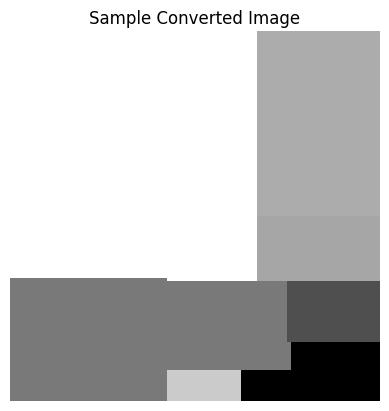

d:\AppsFiles\Anaconda3\envs\tor_env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\AppsFiles\Anaconda3\envs\tor_env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



----- Round 1 Training (each round: 10 epochs) -----
Epoch 1/10 - Train Loss: 0.5524 - Train Acc: 70.36% - Test Loss: 0.6649 - Test Acc: 63.64%
Epoch 2/10 - Train Loss: 0.4813 - Train Acc: 77.52% - Test Loss: 0.4858 - Test Acc: 79.22%
Epoch 3/10 - Train Loss: 0.4565 - Train Acc: 76.87% - Test Loss: 0.5532 - Test Acc: 76.62%
Epoch 4/10 - Train Loss: 0.4372 - Train Acc: 78.50% - Test Loss: 0.5245 - Test Acc: 74.68%
Epoch 5/10 - Train Loss: 0.4386 - Train Acc: 78.34% - Test Loss: 0.5005 - Test Acc: 74.03%
Epoch 6/10 - Train Loss: 0.4312 - Train Acc: 80.13% - Test Loss: 0.5183 - Test Acc: 74.68%
Epoch 7/10 - Train Loss: 0.3828 - Train Acc: 81.11% - Test Loss: 0.4951 - Test Acc: 76.62%
Epoch 8/10 - Train Loss: 0.3772 - Train Acc: 82.25% - Test Loss: 0.5345 - Test Acc: 77.92%
Epoch 9/10 - Train Loss: 0.3631 - Train Acc: 83.55% - Test Loss: 0.5632 - Test Acc: 74.68%
Epoch 10/10 - Train Loss: 0.3653 - Train Acc: 83.55% - Test Loss: 0.5313 - Test Acc: 75.32%
Round 1 -> Test Accuracy: 75.32%
Ro

In [14]:
import os
import numpy as np
import pandas as pd
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import random

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models

# ---------------------- Set random seed ----------------------
random.seed(42)
torch.manual_seed(42)

# ---------------------- 1. Data load and normalization ----------------------
feature_cols = ["Pregnancies", "Glucose", "BloodPressure", "SkinThickness",
                "Insulin", "BMI", "DiabetesPedigreeFunction", "Age"]

data = pd.read_csv('diabetes_dataset_1.csv')
data_norm = data.copy()
for col in feature_cols:
    min_val = data[col].min()
    max_val = data[col].max()
    data_norm[col] = (data[col] - min_val) / (max_val - min_val)

# ---------------------- 2. Use ReliefF to calculate feature importance ----------------------
from skrebate import ReliefF

X = data_norm[feature_cols].values
y = data_norm['Outcome'].values
relief = ReliefF(n_neighbors=10)
relief.fit(X, y)
importance_scores = relief.feature_importances_
ordered_indices = np.argsort(importance_scores)[::-1]
ordered_features = [feature_cols[i] for i in ordered_indices]
print("ReliefF calculated importance order:", ordered_features)

# ---------------------- 3. Generate region mappings ----------------------
predefined_regions = [
    (0, 0, 80, 80),    # Area: 6400, for most important feature
    (80, 0, 40, 60),   # Area: 2400
    (0, 80, 50, 40),   # Area: 2000
    (50, 80, 40, 30),  # Area: 1200
    (80, 60, 40, 20),  # Area: 800
    (90, 80, 30, 20),  # Area: 600
    (50, 110, 25, 10), # Area: 250
    (75, 110, 20, 10)  # Area: 200
]
auto_region_mapping = {}
for i, feat in enumerate(ordered_features):
    auto_region_mapping[feat] = predefined_regions[i]

print("Auto generated region mapping:")
for feat, region in auto_region_mapping.items():
    print(f"{feat}: {region}")

def create_image_from_features(sample, region_mapping):
    """
    Generate a 120x120 grayscale image from a sample.
    """
    img = Image.new('L', (120, 120), color=0)
    draw = ImageDraw.Draw(img)
    for feat in feature_cols:
        val = int(sample[feat] * 255)
        if feat in region_mapping:
            x, y, w, h = region_mapping[feat]
            draw.rectangle([x, y, x + w, y + h], fill=val)
    return img

# 可视化一个样本转换后的图像
sample_img = create_image_from_features(data_norm.iloc[0], auto_region_mapping)
plt.imshow(sample_img, cmap='gray')
plt.title("Sample Converted Image")
plt.axis('off')
plt.show()

# ---------------------- 4. Define PimaImageDataset with orig_index ----------------------
class PimaImageDataset(Dataset):
    def __init__(self, X, y, orig_indices=None, transform=None):
        """
        X: list of images (PIL.Image or tensor)
        y: list of labels
        orig_indices: list of original indices; for original samples, a valid index (0,1,2,...),
                      for augmented samples, use None.
        transform: transformation to apply (e.g., ToTensor)
        """
        self.X = X
        self.y = y
        if orig_indices is None:
            self.orig_indices = list(range(len(X)))
        else:
            self.orig_indices = orig_indices
        self.transform = transform

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        img = self.X[idx]
        label = int(self.y[idx])
        orig_index = self.orig_indices[idx]
        # 如果 orig_index 为 None，则返回 -1 作为占位符
        if orig_index is None:
            orig_index = -1
        if torch.is_tensor(img):
            return img, label, orig_index
        if self.transform:
            img = self.transform(img)
        else:
            img = transforms.ToTensor()(img)
        return img, label, orig_index

# ---------------------- 5. Convert table data to images ----------------------
def convert_to_rgb(img):
    return img.convert('RGB')

def changeToTwoD(dataset, region_mapping):
    features = []
    labels = []
    for idx in range(dataset.shape[0]):
        img = convert_to_rgb(create_image_from_features(dataset.iloc[idx], region_mapping))
        resize = transforms.Resize(size=(224, 224))
        img = resize(img)
        label = int(dataset.iloc[idx]['Outcome'])
        features.append(img)
        labels.append(label)
    return features, labels

# 使用 changeToTwoD 仅生成原始图像，不做几何增广
img_features, img_labels = changeToTwoD(data_norm, auto_region_mapping)
# 为原始样本设置 orig_indices 为 0,1,...,len(img_features)-1
orig_indices = list(range(len(img_features)))

# ---------------------- 6. Split data and build DataLoader ----------------------
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test, orig_train_indices, orig_test_indices = train_test_split(
    img_features, img_labels, orig_indices, test_size=0.2, random_state=42
)

# 定义转换，将 PIL.Image 转为 tensor
to_tensor = transforms.ToTensor()
train_dataset = PimaImageDataset(X_train, y_train, orig_indices=orig_train_indices, transform=to_tensor)
test_dataset = PimaImageDataset(X_test, y_test, orig_indices=orig_test_indices, transform=to_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

# ---------------------- 7. Define and finetune the pretrained ResNet18 Model ----------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet = models.resnet18(pretrained=True)
num_features_model = resnet.fc.in_features
resnet.fc = nn.Linear(num_features_model, 2)  # 2-class classification
model = resnet.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

epochs_per_round = 10
max_num_rounds = 5  # 最大训练轮数（外层迭代）
overall_round = 0
max_duplications = 2
pre_test_acc = 0

# duplication_counts: 针对原始样本（orig_index 不为 None）的复制计数
duplication_counts = {idx: 0 for idx in orig_train_indices}

while overall_round < max_num_rounds:
    overall_round += 1
    print(f"\n----- Round {overall_round} Training (each round: {epochs_per_round} epochs) -----")
    
    # 训练 epochs_per_round 个 epoch
    for epoch in range(epochs_per_round):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for imgs, labels, _ in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * imgs.size(0)
            _, preds = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (preds == labels).sum().item()
        epoch_loss = running_loss / total_train
        train_acc = correct_train / total_train * 100
   
        # 测试集评估
        model.eval()
        running_test_loss = 0.0
        correct_test = 0
        total_test = 0
        with torch.no_grad():
            for imgs, labels, _ in test_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                loss = criterion(outputs, labels)
                running_test_loss += loss.item() * imgs.size(0)
                _, preds = torch.max(outputs, 1)
                total_test += labels.size(0)
                correct_test += (preds == labels).sum().item()
        test_loss = running_test_loss / total_test
        test_acc = correct_test / total_test * 100
        print(f"Epoch {epoch+1}/{epochs_per_round} - Train Loss: {epoch_loss:.4f} - Train Acc: {train_acc:.2f}% - Test Loss: {test_loss:.4f} - Test Acc: {test_acc:.2f}%")

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for imgs, labels, _ in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
    final_test_acc = correct / total * 100
    print(f"Round {overall_round} -> Test Accuracy: {final_test_acc:.2f}%")
    
    
    # 判断改进是否足够显著
    if final_test_acc - pre_test_acc < 1e-4:
        print("Test accuracy improvement is minimal, stopping further rounds.")
        break
    pre_test_acc = test_acc
    
    # ---------------------- Extract misclassified original samples from current training dataset ----------------------
    misclassified_imgs = []
    misclassified_labels = []
    # 遍历整个训练集，不使用 DataLoader（保证顺序一致）
    for i in range(len(train_dataset)):
        img, label, orig_idx = train_dataset[i]
        # 仅对原始样本（orig_idx 不为 None）进行判断
        if orig_idx != -1:
            # 将单个样本添加 batch 维度
            img_input = img.unsqueeze(0).to(device)
            model.eval()
            with torch.no_grad():
                output = model(img_input)
                _, pred = torch.max(output, 1)
            if pred.item() != label:
                # 如果复制次数未达到上限，则复制该样本
                if duplication_counts[orig_idx] < max_duplications:
                    duplication_counts[orig_idx] += 1
                    misclassified_imgs.append(img)  # 原样复制
                    misclassified_labels.append(label)
    print(f"Round {overall_round}: Found {len(misclassified_imgs)} misclassified original samples.")
    if len(misclassified_imgs) == 0:
        print("No misclassified original samples found, stopping further rounds.")
        break

    # ---------------------- Construct new training dataset ----------------------
    # 仅取原始训练数据（即 train_dataset 中 orig_idx 不为 None）的样本
    original_train_imgs = []
    original_train_labels = []
    original_train_orig = []
    for img, label, orig_idx in train_dataset:
        if orig_idx is not None:
            original_train_imgs.append(img)
            original_train_labels.append(label)
            original_train_orig.append(orig_idx)
    # 新训练集 = 原始训练样本 + 新复制的误分类样本（复制样本的 orig_index 设为 None）
    new_train_imgs = original_train_imgs + misclassified_imgs
    new_train_labels = original_train_labels + misclassified_labels
    new_train_orig = original_train_orig + [None] * len(misclassified_imgs)
    
    # 构造新的数据集和 DataLoader
    train_dataset = PimaImageDataset(new_train_imgs, new_train_labels, orig_indices=new_train_orig, transform=to_tensor)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
    print(f"After Round {overall_round}, new training dataset size: {len(train_dataset)}")

# ---------------------- 10. Final evaluation on test set ----------------------
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for imgs, labels, _ in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()
final_test_acc = correct / total * 100
print(f"Final Test Accuracy: {final_test_acc:.2f}%")
